In [44]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [65]:
data = pd.read_csv("../data/2014_loan_data/LoanStats_2014_A.csv", low_memory = False);

In [66]:
columns_to_drop = ['id', 'member_id', 'emp_title']
data = data.drop(columns_to_drop, axis = 1)

In [200]:
def initial_model(df, columns, columns_to_encode, columns_to_normalize):
    min_max_scaler = preprocessing.MinMaxScaler()
    new_df = df.copy()
    new_df = new_df[columns]
    new_df = pd.get_dummies(new_df, dummy_na = True, columns = columns_to_encode)
    new_df['amnt'] = new_df['funded_amnt']
    new_df[columns_to_normalize] = min_max_scaler.fit_transform(new_df[columns_to_normalize])
    return new_df

In [290]:
cols = ['funded_amnt', 'emp_length', 'home_ownership', 'int_rate', 'purpose', 'total_pymnt',
        'annual_inc', 'verification_status', 'dti', 'loan_status', 'revol_util', 'grade', 'term']
cols_encode = ['emp_length', 'home_ownership', 'verification_status', 'grade', 'purpose']
cols_normalize = ['funded_amnt', 'annual_inc', 'dti']

new_df = initial_model(data, cols, cols_encode, cols_normalize)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [291]:
def format_revol(val):
    percent = val[:-1]
    return float(percent)/100

new_df['revol_util'] = new_df['revol_util'].map(format_revol, na_action='ignore')

In [292]:
def format_interest(val):
    percent = val[:-1]
    return float(percent)/100

new_df['int_rate'] = new_df['int_rate'].map(format_interest, na_action='ignore')

In [293]:
def format_term(val):
    term = val[1:3]
    return float(term)/12

new_df['term'] = new_df['term'].map(format_term, na_action = 'ignore')

In [294]:
new_df[new_df['revol_util'].isnull()] = np.mean(new_df['revol_util'])
new_df[new_df['int_rate'].isnull()] = np.mean(new_df['int_rate'])

In [295]:
new_df = new_df[new_df.loan_status != 'Current'];

In [296]:
new_df.groupby('loan_status').size()

loan_status
0.5549454866843405       31
Charged Off           10303
Default                  11
Fully Paid            43787
In Grace Period          96
Late (16-30 days)        49
Late (31-120 days)      177
dtype: int64

In [297]:
new_df['paid'] = 1;
new_df.loc[new_df.loan_status == 'Fully Paid', 'paid'] = 0;
display(new_df.head())

,funded_amnt,int_rate,total_pymnt,annual_inc,dti,loan_status,revol_util,term,emp_length_1 year,emp_length_10+ years,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,amnt,paid
0,0.276471,0.0699,6611.69,0.027749,0.373093,Charged Off,0.316,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10400.0,1
1,0.411765,0.1239,17392.37,0.038027,0.300825,Fully Paid,0.290,5.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15000.0,0
3,0.195588,0.1366,2281.98,0.023638,0.870468,Charged Off,0.919,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7650.0,1
4,0.252941,0.1366,9973.43,0.033402,0.645411,Fully Paid,0.594,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9600.0,0
5,0.600735,0.1559,25512.20,0.030730,0.462366,Fully Paid,0.762,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21425.0,0


In [298]:
data_train, data_test = train_test_split(new_df, test_size=.5, stratify=new_df.paid, random_state=99);

In [299]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

In [300]:
cols_to_drop_training = ['loan_status', 'paid', 'int_rate', 'amnt', 'total_pymnt', 'term']
x_train, y_train = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)

In [268]:
model = LogisticRegressionCV(cv = 5, penalty = 'l2', max_iter = 1000)
model.fit(x_train, y_train);

In [213]:
model.score(x_train, y_train)

0.8064054063980608

In [140]:
model.score(x_test, y_test)

0.806919601865795

In [141]:
predictions = x_train.copy()
predictions['pred'] = model.predict(x_train)
predictions['proba'] = model.predict_proba(x_train)[:, 1]
predictions['true_val'] = y_train

In [142]:
predictions.head()

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,pred,proba,true_val
6459,0.500000,0.037127,0.445861,0.452,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.160359,0
44648,0.752941,0.035971,0.354839,0.427,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.146664,1
21632,0.088235,0.006148,0.396599,0.558,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.300914,0
48888,0.058824,0.016444,0.520130,0.249,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.304211,0
16510,0.680147,0.024920,0.515129,0.733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.256690,0


In [143]:
predictions['class'] = 0;
predictions.loc[predictions.proba > 0.39, 'class'] = 1;
display(predictions.head())

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,pred,proba,true_val,class
6459,0.500000,0.037127,0.445861,0.452,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.160359,0,0
44648,0.752941,0.035971,0.354839,0.427,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.146664,1,0
21632,0.088235,0.006148,0.396599,0.558,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.300914,0,0
48888,0.058824,0.016444,0.520130,0.249,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,0.304211,0,0
16510,0.680147,0.024920,0.515129,0.733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.256690,0,0


In [144]:
accuracy_score(y_train, predictions['class'])

0.7997943218129063

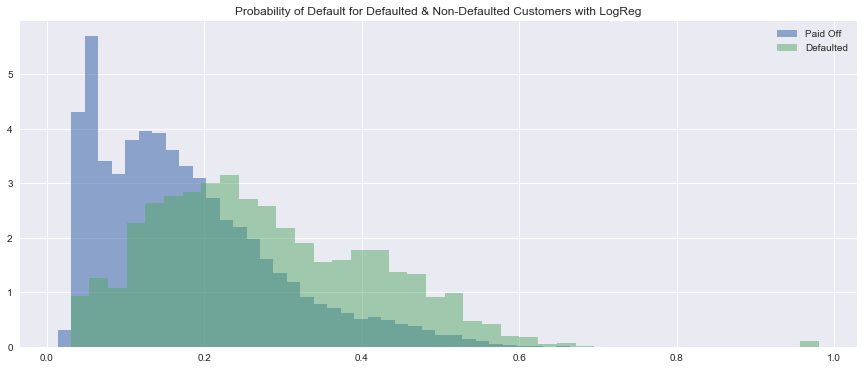

In [145]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);



ax.hist(predictions.loc[predictions.true_val == 0,'proba'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions.loc[predictions.true_val == 1,'proba'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Probability of Default for Defaulted & Non-Defaulted Customers with LogReg')
ax.legend(loc='best')

plt.show()

In [148]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [149]:
lda.predict_proba(x_train)

array([[0.85818129, 0.14181871],
       [0.87365889, 0.12634111],
       [0.6972648 , 0.3027352 ],
       ...,
       [0.37180179, 0.62819821],
       [0.93551026, 0.06448974],
       [0.92179747, 0.07820253]])

In [150]:
predictions_lda = x_train.copy()
predictions_lda['pred'] = lda.predict(x_train)
predictions_lda['proba'] = lda.predict_proba(x_train)[:, 1]
predictions_lda['true_val'] = y_train

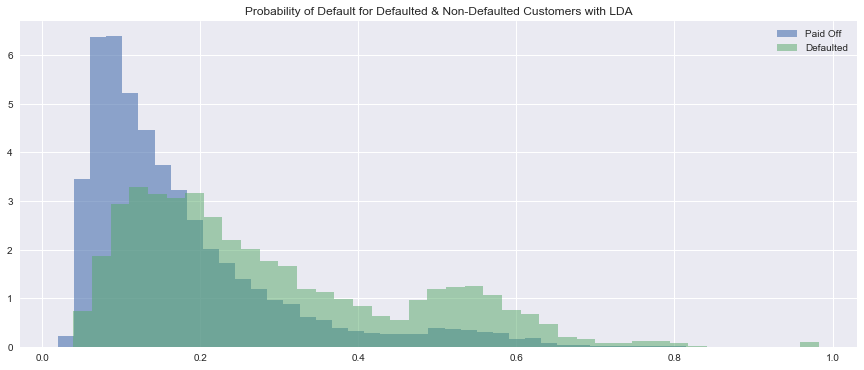

In [151]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_lda.loc[predictions_lda.true_val == 0,'proba'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions_lda.loc[predictions_lda.true_val == 1,'proba'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Probability of Default for Defaulted & Non-Defaulted Customers with LDA')
ax.legend(loc='best')

plt.show()

In [152]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [153]:
qda.predict_proba(x_train)

array([[9.99999958e-01, 4.19221271e-08],
       [1.00000000e+00, 1.05958695e-21],
       [1.00000000e+00, 4.20333673e-41],
       ...,
       [9.99999985e-01, 1.52015971e-08],
       [1.00000000e+00, 1.72496046e-80],
       [1.00000000e+00, 1.01863623e-50]])

In [154]:
rf = RandomForestClassifier(max_depth = 10, n_estimators = 100)
rf.fit(x_train, y_train);

In [155]:
rf.predict_proba(x_train)

array([[0.83285221, 0.16714779],
       [0.83012899, 0.16987101],
       [0.84127084, 0.15872916],
       ...,
       [0.54306662, 0.45693338],
       [0.90605338, 0.09394662],
       [0.89373731, 0.10626269]])

In [156]:
predictions_rf = x_train.copy()
predictions_rf['pred_train'] = rf.predict(x_train)
predictions_rf['proba_train'] = rf.predict_proba(x_train)[:, 1]
predictions_rf['true_val_train'] = y_train

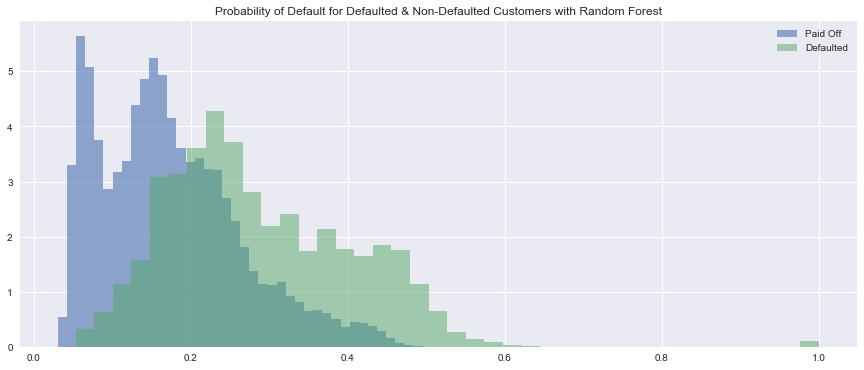

In [157]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_rf.loc[predictions_rf.true_val_train == 0,'proba_train'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions_rf.loc[predictions_rf.true_val_train == 1,'proba_train'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Probability of Default for Defaulted & Non-Defaulted Customers with Random Forest')
ax.legend(loc='best')

plt.show()

In [158]:
predictions_test = x_test.copy()
predictions_test['pred_test'] = rf.predict(x_test)
predictions_test['proba_test'] = rf.predict_proba(x_test)[:, 1]
predictions_test['true_val_test'] = y_test
predictions_test['int_rate'] = data_test['int_rate']

In [159]:
predictions_test.head()

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,pred_test,proba_test,true_val_test,int_rate
12518,0.661029,0.029805,0.485871,0.706,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.353741,1,0.1714
46920,0.776471,0.101747,0.272818,0.645,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.225552,0,0.1629
29904,1.000000,0.043474,0.688422,0.696,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.396058,1,0.1854
16084,0.088235,0.046763,0.328582,0.743,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.125900,0,0.1049
23433,0.058824,0.015930,0.676669,0.662,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.210598,0,0.1366


In [169]:
predictions_test['ROI'] = (predictions_test['int_rate'])*(1-predictions_test['proba_test'])

In [170]:
predictions_test.head()

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,pred_test,proba_test,true_val_test,int_rate,ROI
12518,0.661029,0.029805,0.485871,0.706,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.353741,1,0.1714,0.110769
46920,0.776471,0.101747,0.272818,0.645,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.225552,0,0.1629,0.126158
29904,1.000000,0.043474,0.688422,0.696,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.396058,1,0.1854,0.111971
16084,0.088235,0.046763,0.328582,0.743,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.125900,0,0.1049,0.091693
23433,0.058824,0.015930,0.676669,0.662,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.210598,0,0.1366,0.107832


In [171]:
#predictions_test = predictions_test.sort_values(by = ["ROI"], axis = 0)

In [172]:
#predictions_test.head()

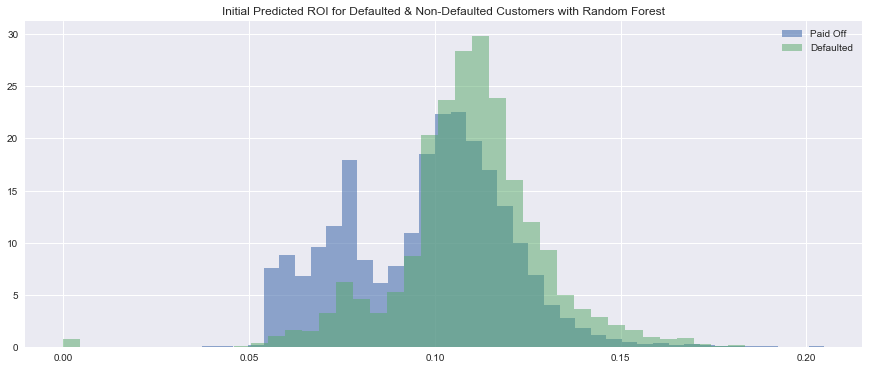

In [173]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_test.loc[predictions_test.true_val_test == 0,'ROI'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions_test.loc[predictions_test.true_val_test == 1,'ROI'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Random Forest')
ax.legend(loc='best')

plt.show()

In [165]:
#create a function to take advantage of sklearn make_pipeline
#pipeline adds second order terms and interaction terms to X_train and then fits model
def complex_model(X, y):
    model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(cv = 5, penalty = 'l2', max_iter = 10000))
    model.fit(X, y)
    return model

model_complex = complex_model(x_train, y_train)

In [166]:
model_complex.predict_proba(x_train)

array([[0.85630811, 0.14369189],
       [0.85386224, 0.14613776],
       [0.74548413, 0.25451587],
       ...,
       [0.48466458, 0.51533542],
       [0.92986643, 0.07013357],
       [0.9217841 , 0.0782159 ]])

In [167]:
predictions_complex = x_train.copy()
predictions_complex['pred'] = model_complex.predict(x_train)
predictions_complex['proba'] = model_complex.predict_proba(x_train)[:, 1]
predictions_complex['true_val'] = y_train

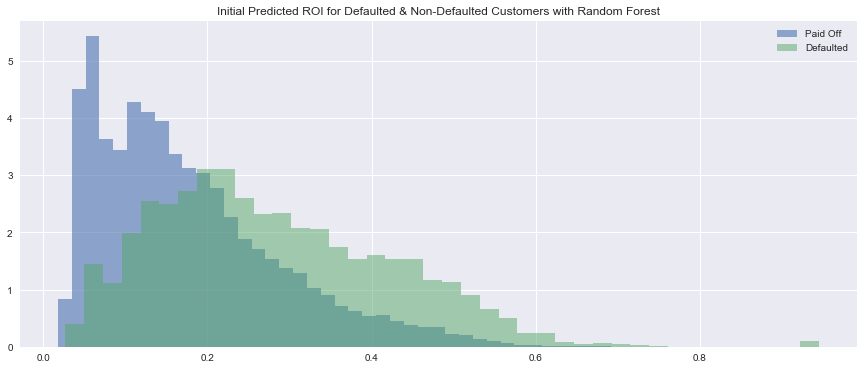

In [168]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_complex.loc[predictions_complex.true_val == 0,'proba'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions_complex.loc[predictions_complex.true_val == 1,'proba'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Random Forest')
ax.legend(loc='best')

plt.show()

In [179]:
#create a function to take advantage of sklearn make_pipeline
#pipeline adds second order terms and interaction terms to X_train and then fits model
def rf_model(X, y):
    model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    RandomForestClassifier(max_depth = 10, n_estimators = 10))
    model.fit(X, y)
    return model

rf_complex = rf_model(x_train, y_train)

In [180]:
predictions_complex_rf = x_train.copy()
predictions_complex_rf['pred'] = rf_complex.predict(x_train)
predictions_complex_rf['proba'] = rf_complex.predict_proba(x_train)[:, 1]
predictions_complex_rf['true_val'] = y_train

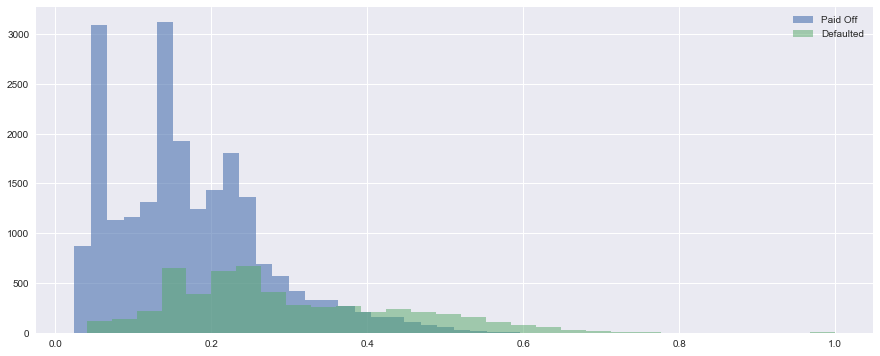

In [301]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_complex_rf.loc[predictions_complex_rf.true_val == 0,'proba'], bins = 30, label='Paid Off', alpha=0.6);
ax.hist(predictions_complex_rf.loc[predictions_complex_rf.true_val == 1,'proba'], bins = 30, label='Defaulted', alpha=0.5);
ax.legend(loc='best')

plt.show()

In [440]:
predictions_complex_rf['int_rate'] = data_train['int_rate']
predictions_complex_rf['amnt'] = data_train['amnt']
predictions_complex_rf['total_pymnt'] = data_train['total_pymnt']
predictions_complex_rf['term'] = data_train['term']
predictions_complex_rf['ROI'] = (predictions_complex_rf['int_rate'])*(1-predictions_complex_rf['proba'])

predictions_complex_rf['Real_ROI'] = predictions_complex_rf['amnt']*(((predictions_complex_rf['total_pymnt']/predictions_complex_rf['amnt'])**(1/predictions_complex_rf['term']))-1)
predictions_complex_rf['annualized_amnt'] = predictions_complex_rf['amnt']*(1/predictions_complex_rf['term'])

In [441]:
predictions_complex_rf.head()

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,pred,proba,true_val,int_rate,ROI,amnt,total_pymnt,term,Real_ROI,annualized_amnt
6459,0.500000,0.037127,0.445861,0.452,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.143467,0,0.0867,0.074261,18000.0,20504.744564,3.0,798.929733,6000.000000
44648,0.752941,0.035971,0.354839,0.427,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0.157510,1,0.0917,0.077256,26600.0,5270.300000,5.0,-7357.017862,5320.000000
21632,0.088235,0.006148,0.396599,0.558,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.139027,0,0.1714,0.147571,4000.0,4816.050000,3.0,255.366692,1333.333333
48888,0.058824,0.016444,0.520130,0.249,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.205017,0,0.1699,0.135068,3000.0,3687.800000,3.0,213.684882,1000.000000
16510,0.680147,0.024920,0.515129,0.733,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.213609,0,0.1366,0.107421,24125.0,28697.960004,3.0,1437.023121,8041.666667


In [442]:
print(np.sum(predictions_complex_rf['Real_ROI']))
print(np.sum(predictions_complex_rf['annualized_amnt']))
print(np.sum(predictions_complex_rf['Real_ROI'])/np.sum(predictions_complex_rf['annualized_amnt']))

3583094.1548627666
111550087.99999999
0.032120944224291126


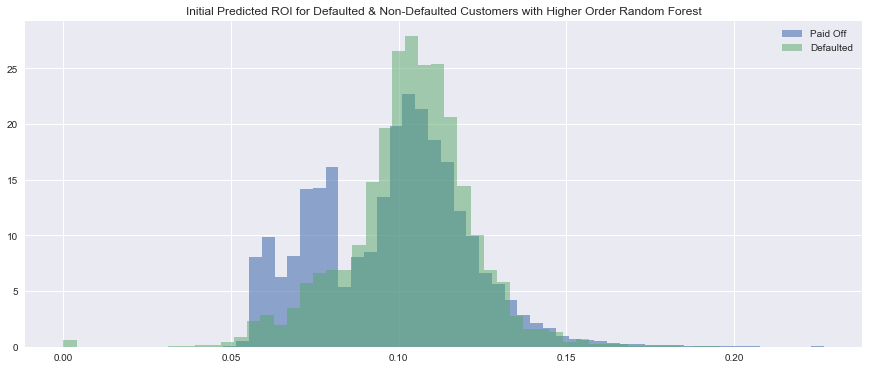

In [466]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_complex_rf.loc[predictions_complex_rf.true_val == 0,'ROI'], density = True, bins = 50, label='Paid Off', alpha=0.6);
ax.hist(predictions_complex_rf.loc[predictions_complex_rf.true_val == 1,'ROI'], density = True, bins = 50, label='Defaulted', alpha=0.5);
ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Higher Order Random Forest')
ax.legend(loc='best')

plt.show()

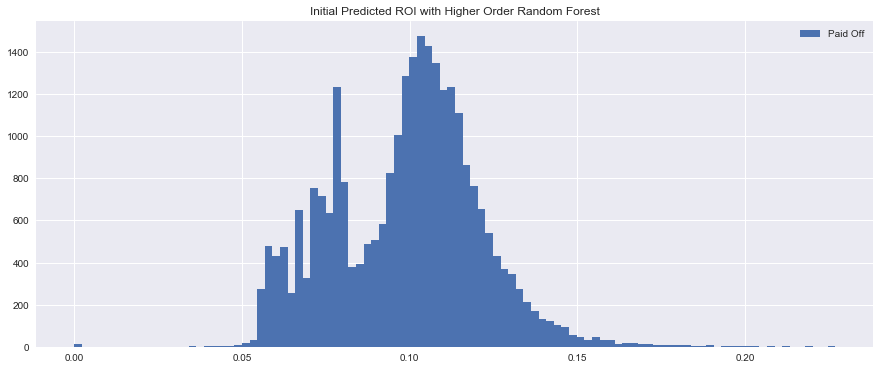

In [444]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_complex_rf['ROI'], bins = 100, label='Paid Off')
ax.set_title('Initial Predicted ROI with Higher Order Random Forest')
ax.legend(loc='best')

plt.show()

In [445]:
baseline = predictions_complex_rf.groupby(['true_val']).agg({
    'ROI' : np.mean
})

baseline.head()

,ROI
true_val,
0,0.098166
1,0.103212


In [462]:
final_base = baseline['ROI'][0]*0.7

In [463]:
loans_to_buy = predictions_complex_rf[predictions_complex_rf.ROI < final_base]

In [464]:
display(loans_to_buy.head())
display(loans_to_buy.shape)

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,pred,proba,true_val,int_rate,ROI,amnt,total_pymnt,term,Real_ROI,annualized_amnt
4965,0.264706,0.046711,0.370093,0.641,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0.047386,0,0.0699,0.066588,10000.0,11065.450704,3.0,343.234457,3333.333333
14102,0.033824,0.016444,0.493373,0.353,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0.056041,0,0.0699,0.065983,2150.0,2309.600000,3.0,51.935349,716.666667
1502,0.264706,0.051387,0.358590,0.168,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.041909,0,0.0603,0.057773,10000.0,10859.008415,3.0,278.507487,3333.333333
14971,0.252941,0.045221,0.776944,0.845,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0.079467,0,0.0699,0.064345,9600.0,10662.069852,3.0,341.715477,3200.000000
54909,0.705882,0.100719,0.551888,0.451,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0.045148,0,0.0603,0.057578,25000.0,27375.223442,3.0,767.912080,8333.333333


(2721, 56)

In [465]:
np.sum(loans_to_buy['Real_ROI'])/np.sum(loans_to_buy['annualized_amnt'])

0.04421121099242671